In [190]:
# Standardize data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("raw_dataset.csv")
X = df.iloc[:, :].values.copy()
target_all_total = df['total_UPDRS'].values
target_all_motor = df['motor_UPDRS'].values
mean = np.mean(X, axis=0)
scale = np.std(X, axis=0)
X_std = (X - mean) / scale


In [191]:
# Eigendecomposition of covariance matrix
cov_mat = np.cov(X_std.T)

In [192]:
from numpy import array, identity, diagonal
from math import sqrt


def jacobi(a, tol=1.0e-9):  # Jacobi method

    def maxElem(a):  # Find largest off-diag. element a[k,l]
        n = len(a)
        aMax = 0.0
        for i in range(n - 1):
            for j in range(i + 1, n):
                if abs(a[i, j]) >= aMax:
                    aMax = abs(a[i, j])
                    k = i;
                    l = j
        return aMax, k, l

    def rotate(a, p, k, l):  # Rotate to make a[k,l] = 0
        n = len(a)
        aDiff = a[l, l] - a[k, k]
        if abs(a[k, l]) < abs(aDiff) * 1.0e-36:
            t = a[k, l] / aDiff
        else:
            phi = aDiff / (2.0 * a[k, l])
            t = 1.0 / (abs(phi) + sqrt(phi ** 2 + 1.0))
            if phi < 0.0: t = -t
        c = 1.0 / sqrt(t ** 2 + 1.0);
        s = t * c
        tau = s / (1.0 + c)
        temp = a[k, l]
        a[k, l] = 0.0
        a[k, k] = a[k, k] - t * temp
        a[l, l] = a[l, l] + t * temp
        for i in range(k):  # Case of i < k
            temp = a[i, k]
            a[i, k] = temp - s * (a[i, l] + tau * temp)
            a[i, l] = a[i, l] + s * (temp - tau * a[i, l])
        for i in range(k + 1, l):  # Case of k < i < l
            temp = a[k, i]
            a[k, i] = temp - s * (a[i, l] + tau * a[k, i])
            a[i, l] = a[i, l] + s * (temp - tau * a[i, l])
        for i in range(l + 1, n):  # Case of i > l
            temp = a[k, i]
            a[k, i] = temp - s * (a[l, i] + tau * temp)
            a[l, i] = a[l, i] + s * (temp - tau * a[l, i])
        for i in range(n):  # Update transformation matrix
            temp = p[i, k]
            p[i, k] = temp - s * (p[i, l] + tau * p[i, k])
            p[i, l] = p[i, l] + s * (temp - tau * p[i, l])

    n = len(a)
    maxRot = 5 * (n ** 2)  # Set limit on number of rotations
    p = identity(n) * 1.0  # Initialize transformation matrix
    for i in range(maxRot):  # Jacobi rotation loop 
        aMax, k, l = maxElem(a)
        if aMax < tol: return diagonal(a), p
        rotate(a, p, k, l)
    print('Jacobi method did not converge')

In [193]:
eig_vals, eig_vecs = jacobi(cov_mat)

In [194]:
# Adjusting the eigenvectors that are largest in absolute value to be positive
max_abs_idx = np.argmax(np.abs(eig_vecs), axis=0)
signs = np.sign(eig_vecs[max_abs_idx, range(eig_vecs.shape[0])])
eig_vecs = eig_vecs * signs[np.newaxis, :]
eig_vecs = eig_vecs.T

eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[i, :]) for i in range(len(eig_vals))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)
eig_vals_sorted = np.array([x[0] for x in eig_pairs])
eig_vecs_sorted = np.array([x[1] for x in eig_pairs])
n_components = 11
components = eig_vecs_sorted[:n_components, :]



In [195]:
# Explained variance ratio
explained_variance_ratio = [i / np.sum(eig_vals) for i in eig_vals_sorted[:n_components]]

cum_explained_variance = np.cumsum(explained_variance_ratio)

Components:
 [[ 5.45335563e-02  2.73216904e-02  1.06219527e-02 -9.58278928e-03
   4.12278663e-02  3.94275708e-02  2.65414048e-01  2.47925771e-01
   2.57459296e-01  2.63550999e-01  2.57460801e-01  2.77600822e-01
   2.77946432e-01  2.67976258e-01  2.73501681e-01  2.61317108e-01
   2.67975837e-01  2.57408554e-01 -2.56673062e-01  1.67637721e-01
   6.88921201e-02  2.29915396e-01]
 [ 2.15210580e-01  3.19141812e-01 -3.49677669e-02  7.59962227e-02
   6.12995629e-01  6.21577338e-01 -8.68806318e-02 -8.06341566e-02
  -9.99935726e-02 -8.75571432e-02 -9.99851127e-02  1.56923101e-02
   2.06659414e-02  9.15807425e-03  1.00434080e-02  5.31989865e-02
   9.15826377e-03 -4.61827040e-02 -6.08370981e-02  9.29058246e-02
  -1.47154010e-01  3.32977985e-02]
 [ 9.78598147e-03 -4.65453974e-02 -2.73951686e-01  6.50137727e-02
   1.18781932e-01  1.37582583e-01  2.32914727e-01  3.14219183e-01
   2.33653740e-01  1.56304828e-01  2.33659971e-01 -2.45401667e-01
  -2.33699290e-01 -2.67629532e-01 -2.59909702e-01 -2.231610

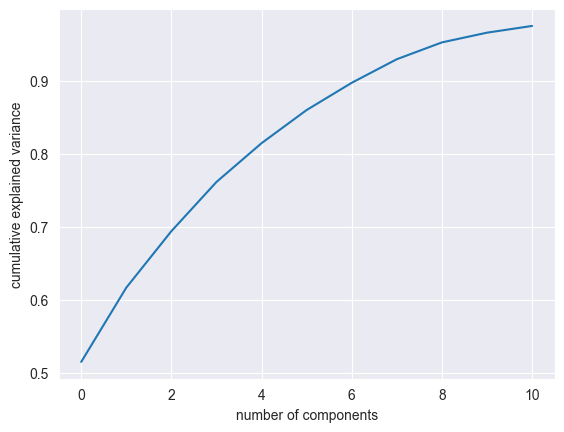

In [196]:
# Transform data
X_proj = X_std.dot(components.T)

print('Components:\n', components)
print('Explained variance ratio from scratch:\n', explained_variance_ratio)
print('Cumulative explained variance from scratch:\n', cum_explained_variance)

plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

print('Transformed data shape from scratch:', X_proj.shape)

In [197]:
from sklearn.preprocessing import StandardScaler

X_std = StandardScaler().fit_transform(X)

from sklearn.decomposition import PCA

pca = PCA(n_components=11).fit(X_std)

print('Components:\n', pca.components_)
print('Explained variance ratio:\n', pca.explained_variance_ratio_)

cum_explained_variance = np.cumsum(pca.explained_variance_ratio_)
print('Cumulative explained variance:\n', cum_explained_variance)

X_pca_our = pca.transform(X_std)  # Apply dimensionality reduction to X.
print('Transformed data shape:', X_pca_our.shape)


Components:
 [[ 5.45335563e-02  2.73216904e-02  1.06219527e-02 -9.58278928e-03
   4.12278663e-02  3.94275708e-02  2.65414048e-01  2.47925771e-01
   2.57459296e-01  2.63550999e-01  2.57460801e-01  2.77600822e-01
   2.77946432e-01  2.67976258e-01  2.73501681e-01  2.61317108e-01
   2.67975837e-01  2.57408554e-01 -2.56673062e-01  1.67637721e-01
   6.88921201e-02  2.29915396e-01]
 [-2.15210581e-01 -3.19141812e-01  3.49677662e-02 -7.59962225e-02
  -6.12995629e-01 -6.21577338e-01  8.68806315e-02  8.06341566e-02
   9.99935723e-02  8.75571428e-02  9.99851124e-02 -1.56923099e-02
  -2.06659413e-02 -9.15807408e-03 -1.00434079e-02 -5.31989863e-02
  -9.15826360e-03  4.61827038e-02  6.08370979e-02 -9.29058242e-02
   1.47154011e-01 -3.32977983e-02]
 [-9.78598147e-03  4.65453974e-02  2.73951686e-01 -6.50137727e-02
  -1.18781932e-01 -1.37582583e-01 -2.32914727e-01 -3.14219183e-01
  -2.33653740e-01 -1.56304828e-01 -2.33659971e-01  2.45401667e-01
   2.33699290e-01  2.67629532e-01  2.59909702e-01  2.231610

In [198]:
df.drop(['subject#'], axis=1, inplace=True)

In [199]:
df.head()

,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,0.01204,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,0.00395,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,0.00616,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,0.00573,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,0.00278,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [200]:
df.columns

Index(['age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS', 'Jitter(%)',
       'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer',
       'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11',
       'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE'],
      dtype='object')

In [201]:
X = df[['age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS',
        'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP',
        'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
        'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']].values
y = df['motor_UPDRS'].values

In [202]:
X

array([[7.2000e+01, 0.0000e+00, 5.6431e+00, ..., 4.1888e-01, 5.4842e-01,
        1.6006e-01],
       [7.2000e+01, 0.0000e+00, 1.2666e+01, ..., 4.3493e-01, 5.6477e-01,
        1.0810e-01],
       [7.2000e+01, 0.0000e+00, 1.9681e+01, ..., 4.6222e-01, 5.4405e-01,
        2.1014e-01],
       ...,
       [6.1000e+01, 0.0000e+00, 1.5682e+02, ..., 4.7792e-01, 5.7888e-01,
        1.4157e-01],
       [6.1000e+01, 0.0000e+00, 1.6373e+02, ..., 5.6865e-01, 5.6327e-01,
        1.4204e-01],
       [6.1000e+01, 0.0000e+00, 1.7073e+02, ..., 5.8608e-01, 5.7077e-01,
        1.5336e-01]])

In [203]:
y

array([28.199, 28.447, 28.695, ..., 21.495, 21.007, 20.513])

In [204]:
## Random Forest with PCA built-in function

In [205]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np

# Спочатку масштабуємо дані
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Зменшуємо розмірність датасету з PCA
pca = PCA(n_components=11)
X_pca = pca.fit_transform(X_scaled)

In [206]:
X_pca

array([[-0.89034346, -1.0398599 ,  0.05935904, ..., -0.30848475,
         0.38853391, -0.52679491],
       [-2.50941747, -1.26564907,  0.54869368, ...,  0.2127456 ,
        -0.09651752,  0.09955513],
       [-1.84565013, -1.36027744, -0.18271938, ..., -0.74042271,
        -0.17914241, -0.18409323],
       ...,
       [-1.78042602, -0.41470279,  0.43092736, ...,  0.02683676,
         0.05360442,  0.00681354],
       [-2.47233571, -0.47682411, -0.15374494, ...,  0.22263392,
        -0.03637864,  0.06455065],
       [-2.04951452, -0.45772885, -0.02638035, ...,  0.21527912,
         0.02648354, -0.00420543]])

In [207]:
# Розділяємо дані на навчальний та тестувальний набори
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.25, random_state=0)

# Ініціалізуємо та навчаємо модель Random Forest
regressor = RandomForestRegressor(n_estimators=150, random_state=0)
regressor.fit(X_train, y_train)

# Робимо прогнози на тестувальному наборі
y_pred = regressor.predict(X_test)

# Оцінюємо точність моделі
explained_variance = metrics.explained_variance_score(y_test, y_pred)
mean_absolute_error = metrics.mean_absolute_error(y_test, y_pred)
mean_squared_error = metrics.mean_squared_error(y_test, y_pred)

explained_variance, mean_absolute_error, mean_squared_error

(0.987975640890956, 0.5411794363512585, 0.7833146309762642)

In [208]:
## Random Forest with Our PCA 

In [209]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Спочатку масштабуємо дані
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_pca = X_pca_our


In [210]:
X_pca

array([[-0.97951267, -0.63742095,  0.07976055, ..., -0.196334  ,
        -0.26969151,  0.30029981],
       [-2.5958211 , -0.87163904,  0.57072394, ..., -0.12000569,
         0.24109615, -0.18047512],
       [-1.9325361 , -0.9668129 , -0.16052805, ..., -0.41161484,
        -0.70448178, -0.26933904],
       ...,
       [-1.68814873, -0.7500151 ,  0.41723183, ...,  1.77999844,
        -0.05093947,  0.23234827],
       [-2.37861284, -0.82717451, -0.1675603 , ...,  1.57565799,
         0.14818425,  0.13059133],
       [-1.95649274, -0.79775419, -0.03909706, ...,  1.49964565,
         0.14406023,  0.18807437]])

In [211]:
# Розділяємо дані на навчальний та тестувальний набори
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.25, random_state=0)



In [212]:
y

array([28.199, 28.447, 28.695, ..., 21.495, 21.007, 20.513])

In [213]:
# Ініціалізуємо та навчаємо модель Random Forest
regressor = RandomForestRegressor(n_estimators=150, random_state=0)
regressor.fit(X_train, y_train)

# Робимо прогнози на тестувальному наборі
y_pred = regressor.predict(X_test)

# Оцінюємо точність моделі
explained_variance = metrics.explained_variance_score(y_test, y_pred)
mean_absolute_error = metrics.mean_absolute_error(y_test, y_pred)
mean_squared_error = metrics.mean_squared_error(y_test, y_pred)

explained_variance, mean_absolute_error, mean_squared_error

(0.989975772200472, 0.5066724588155208, 0.6529865449936967)